# rACS in Real-Multiplexer

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration

# Load OpenAI environments
import gym
import gym_multiplexer

## Real-Multiplexer
In 3-bit multiplexer first bit is responsible for addressing the correct answer.

> For testing purposes the last bit is used as a flag indicating if the action chosen by the algorithm was correct. The environment always introduces it with 0. It's value is changed to 1 if the action was chosen correctly.

In [2]:
# Environment initialization
rmpx = gym.make('real-multiplexer-3bit-v0')

rMPX acts like a normal MPX with the difference that instead on boolean values floating numbers within range `[0,1]` are used. Environment used internal threshold to transform them into boolean values (`threshold=0.5` is used as default).

In [3]:
state = rmpx.reset()
state

[0.5011231257447775, 0.19318937038647, 0.36885879131855603, 0]

Which corresponds to the following binary MPX:

In [4]:
threshold = 0.5  # secret knowledge
binary_state = map(lambda x: 1 if x > threshold else 0, state)

list(binary_state)

[1, 0, 0, 0]

Depending on the MPX size we have some actions to be executed. In 3-bit variant first bit (_address bit_) points to the correct answer (two possible values).

In [5]:
rmpx.action_space.n

2

We can also investigate the properties of a single observation (like vector dimension, lower and upper bound of each attribute).

In [6]:
print(f"Observation shape: {rmpx.observation_space.shape}")
print(f"Upper bounds: {rmpx.observation_space.low}")
print(f"Lower bounds: {rmpx.observation_space.high}")

Observation shape: (4,)
Upper bounds: [0. 0. 0. 0.]
Lower bounds: [1. 1. 1. 1.]


## rACS

- write abount _encoders_

In [7]:
def encode(bits, val):
    return int(RealValueEncoder(bits).encode(val))


r = np.arange(0, 1.1, .1)

df = pd.DataFrame(r, columns=['Perception'])

for bit in [1, 2, 3, 4, 5, 6, 7]:
    df[f'{bit}-bit'] = df.apply(lambda row: encode(bit, row['Perception']), axis=1)

df.set_index('Perception', inplace=True)
df

,1-bit,2-bit,3-bit,4-bit,5-bit,6-bit,7-bit
Perception,,,,,,,
0.0,0,0,0,0,0,0,0
0.1,0,0,0,1,3,6,12
0.2,0,0,1,3,6,12,25
0.3,0,1,2,4,9,19,38
0.4,0,1,3,6,12,25,51
0.5,1,2,4,8,16,32,64
0.6,1,2,4,9,19,38,76
0.7,1,2,5,11,22,44,89
0.8,1,3,6,12,25,51,102


## Experiment
In the experiment each attribute range will be represented as an _unorded bounded tuple_ with desired encoding resolution.

In [8]:
# Define function for fetching interesing metrics
def rmpx_metrics(population, environment):
    return {
        'population': len(population),
        'numerosity': sum(cl.num for cl in population),
        'reliable': len([cl for cl in population if cl.is_reliable()]),
    }

Define a function for executing experiments

In [9]:
def perform_experiment(env, encoder_bits, trials):
    # create configuration
    cfg = Configuration(env.observation_space.shape[0], env.action_space.n,
                    encoder=RealValueEncoder(encoder_bits),
                    metrics_trial_frequency=5,
                    user_metrics_collector_fcn=rmpx_metrics,
                    epsilon=1.0,  # no biased exploration
                    do_ga=True,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.2,  # inadequacy threshold
                    theta_ga=100,
                    cover_noise=0,
                    mutation_noise=0.25,
                    chi=1.0,  # cross-over probability
                    mu=0.1)  # mutation probability
    
    # create agent
    agent = RACS(cfg)
    
    # run computations
    population, metrics = agent.explore_exploit(env, trials)
    
    return population, metrics

## Data visualization

In [10]:
def parse_metrics(metrics):
    lst = [[d['trial'], d['reward'], d['population'], d['reliable']] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'reward', 'population', 'reliable'])
    df = df.set_index('trial')
    df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")

    return df

In [11]:
def plot_results(metrics, env, encoder_bits):
    # parse metrics into data frame
    df = parse_metrics(metrics)
    
    # separate explore/exploit data
    explore_df = df[df['mode'] == 'explore']
    exploit_df = df[df['mode'] == 'exploit']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.suptitle(f"{env.env.spec.id}, ubr encoder bits: {encoder_bits}", fontsize=14)
    
    # plot 1 - average reward
    explore_df['reward'].rolling(window=50).mean().plot(label='explore', ax=ax1)
    exploit_df['reward'].rolling(window=50).mean().plot(label='exploit', ax=ax1)

    ax1.axhline(y=500, color='black', linestyle='--', linewidth=1)
    ax1.axhline(y=1000, color='black', linestyle='--', linewidth=1)

    # ax1.annotate('maximum reward', xy=(500, 950), xycoords='data')
        
    ax1.set_title('Average reward')
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Average reward')
    ax1.set_ylim(400, 1100)
    ax1.legend()
    
    # plot 2 - number of classifiers
    df['population'].plot(label='population', ax=ax2)
    df['reliable'].plot(label='reliable', ax=ax2)
    
    ax2.set_title("Classifiers evolution")
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('# Classifiers')
    ax2.legend()
    
    f.savefig("foo.pdf", bbox_inches='tight')

## Experiments

In [12]:
def evaluate(rmpx, encoder_bits, trials=10_000):
    population, metrics = perform_experiment(rmpx, encoder_bits=encoder_bits, trials=trials)
    plot_results(metrics, rmpx, encoder_bits)
    
    # sort classifiers in population according to action
    population = sorted(population, key=lambda cl: cl.action)

    return population, metrics

### 3-bit rMPX

In [13]:
rmpx3 = gym.make('real-multiplexer-3bit-v0')

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 13, 'numerosity': 168, 'reliable': 11}


CPU times: user 9.5 s, sys: 138 ms, total: 9.63 s
Wall time: 9.5 s


([.O|OO|.O|OO	0	OO|OO|OO|OO x 20 fitness: 0.00,
  .O|O.|O.|O.	0	OO|OO|OO|.O x 1 fitness: 500.00,
  .O|.O|O.|O.	0	OO|OO|OO|.O x 20 fitness: 500.00,
  O.|.O|OO|OO	0	OO|OO|OO|OO x 20 fitness: 0.00,
  O.|O.|OO|O.	0	OO|OO|OO|.O x 5 fitness: 625.00,
  OO|O.|O.|O.	0	OO|OO|OO|.O x 19 fitness: 625.00,
  .O|OO|.O|O.	1	OO|OO|OO|.O x 20 fitness: 625.00,
  O.|.O|OO|O.	1	OO|OO|OO|.O x 20 fitness: 625.00,
  .O|OO|O.|OO	1	OO|OO|OO|OO x 20 fitness: 0.00,
  O.|O.|OO|OO	1	OO|OO|OO|OO x 20 fitness: 0.00],
 [{'trial': 0,
   'steps_in_trial': 1,
   'reward': 0,
   'population': 1,
   'numerosity': 1,
   'reliable': 0},
  {'trial': 5,
   'steps_in_trial': 1,
   'reward': 0,
   'population': 3,
   'numerosity': 3,
   'reliable': 0},
  {'trial': 10,
   'steps_in_trial': 1,
   'reward': 0,
   'population': 4,
   'numerosity': 4,
   'reliable': 0},
  {'trial': 15,
   'steps_in_trial': 1,
   'reward': 0,
   'population': 5,
   'numerosity': 5,
   'reliable': 0},
  {'trial': 20,
   'steps_in_trial': 1,
   'reward'

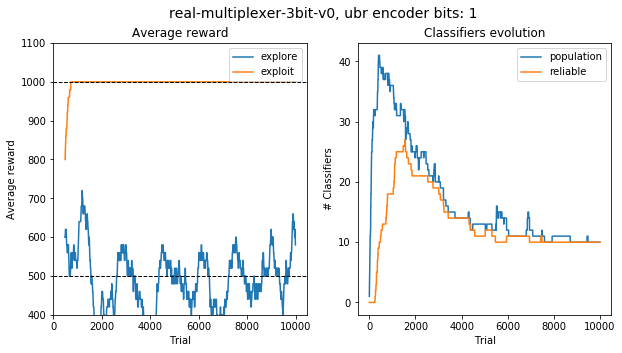

In [14]:
%%time
evaluate(rmpx3, encoder_bits=1, trials=10_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 94, 'numerosity': 579, 'reliable': 48}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 1000, 'population': 37, 'numerosity': 521, 'reliable': 30}


CPU times: user 35.8 s, sys: 416 ms, total: 36.2 s
Wall time: 39.9 s


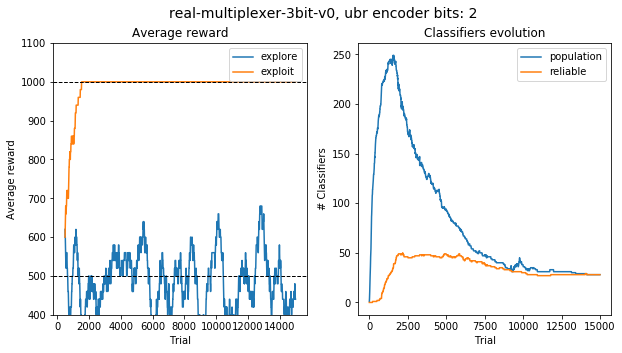

In [17]:
%%time
pop3, m3 = evaluate(rmpx3, encoder_bits=2, trials=15_000)

In [16]:
from itertools import groupby

rel = [cl for cl in pop3 if cl.is_reliable()]

for k, g in groupby(rel, key=lambda cl: cl.action):
    niche = list(g)
    print(f'\nAction: {k}, classifiers: {len(niche)}')
    for cl in sorted(niche, key=lambda cl: -cl.fitness):
        print(f'{cl}')

NameError: name 'pop3' is not defined

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 1328, 'numerosity': 2318, 'reliable': 37}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 0, 'population': 1470, 'numerosity': 3112, 'reliable': 81}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 1000, 'population': 1403, 'numerosity': 3597, 'reliable': 97}


CPU times: user 8min 4s, sys: 3.04 s, total: 8min 7s
Wall time: 8min 29s


([OOOOOOOO|OOOOOOOO|..O.....|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 1 fitness: 135.75,
  OOOOOOOO|.O......|OOOOOOOO|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 1 fitness: 138.70,
  ......O.|OOOOOOOO|...O....|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 4 fitness: 174.94,
  .......O|OOOOOOOO|...O....|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 3 fitness: 127.21,
  ...O....|...O....|..O.....|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 1 fitness: 31.58,
  OOOOOOOO|...O....|..O.....|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 1 fitness: 141.62,
  ...O....|...O....|OOOOOOOO|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 1 fitness: 134.30,
  ..O.....|.......O|OOOOOOOO|OOOOOOOO	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|OOOOOOOO x 20 fitness: 1.28,
  ....O...|.......O|.......O|OOOOOOOO	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|OOOOOOOO x 1 fitness: 51.62,
  OOOOOOOO|.O......|...O....|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|...OOO.. x 1 fitness: 164.92,
  ...O....|O.......|...O....|.O..

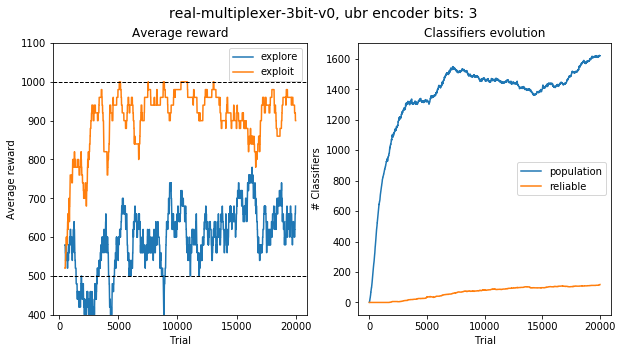

In [18]:
%%time
evaluate(rmpx, encoder_bits=3, trials=20_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 3550, 'numerosity': 4698, 'reliable': 13}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 1000, 'population': 4823, 'numerosity': 7448, 'reliable': 27}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 1000, 'population': 5580, 'numerosity': 9320, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 1, 'reward': 0, 'population': 6153, 'numerosity': 10880, 'reliable': 48}
INFO:lcs.agents.Agent:{'trial': 25000, 'steps_in_trial': 1, 'reward': 0, 'population': 6652, 'numerosity': 12273, 'reliable': 79}
INFO:lcs.agents.Agent:{'trial': 30000, 'steps_in_trial': 1, 'reward': 1000, 'population': 7044, 'numerosity': 13501, 'reliable': 122}
INFO:lcs.agents.Agent:{'trial': 35000, 'steps_in_trial': 1, 'reward': 0, 'population': 7221, 'nu

([OOOOOOOOOO|.O........|OOOOOOOOOO|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 206.98,
  OOOOOOOOOO|OOOOOOOOOO|.....O....|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 65.21,
  OOOOOOOOOO|OOOOOOOOOO|....O.....|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 168.97,
  OOOOOOOOOO|O.........|OOOOOOOOOO|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 172.61,
  ......O...|OOOOOOOOOO|OOOOOOOOOO|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 108.35,
  OOOOOOOOOO|........O.|OOOOOOOOOO|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 94.34,
  OOOOOOOOOO|.O........|OOOOOOOOOO|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 122.90,
  OOOOOOOOOO|..O.......|OOOOOOOOOO|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 184.67,
  O.........|....O.....|...O......|..OOO.....	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fi

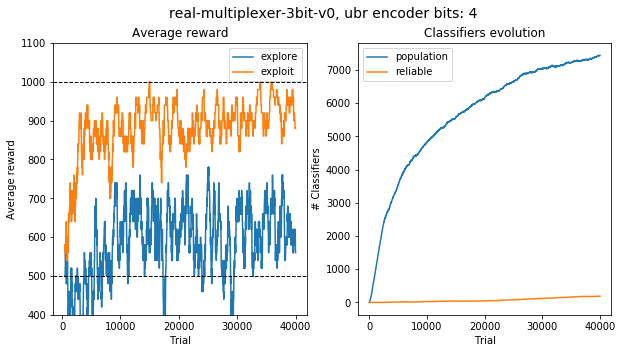

In [19]:
#%%time
evaluate(rmpx, encoder_bits=4, trials=40_000)

In [ ]:
# %%time
# evaluate(rmpx, encoder_bits=5)

### 6-bit rMPX

In [21]:
rmpx6 = gym.make('real-multiplexer-6bit-v0')

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 3066, 'numerosity': 3987, 'reliable': 23}


CPU times: user 10min 31s, sys: 6.94 s, total: 10min 38s
Wall time: 11min 10s


([...O|..O.|O...|..O.|.O..|..O.|OOOO	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|OOOO x 1 fitness: 50.69,
  ...O|..O.|.O..|..O.|..O.|.O..|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 57.44,
  ..O.|O...|.O..|.O..|O...|O...|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 46.02,
  ...O|..O.|.O..|..O.|O...|..O.|OOOO	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|OOOO x 1 fitness: 72.91,
  ..O.|...O|..O.|O...|O...|O...|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 60.64,
  O...|...O|...O|.O..|..O.|...O|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 58.65,
  O...|...O|...O|O...|...O|...O|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 54.79,
  .O..|...O|..O.|..O.|.O..|..O.|OOOO	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|OOOO x 1 fitness: 69.35,
  ...O|..O.|.O..|...O|...O|.O..|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 56.36,
  ...O|O...|..O.|O...|O...|O...|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 2 fitness: 102.88,
  ...O|...O|..O.|.O..|...O|..O.|OOOO	0	OOOO|OOOO|OOOO|OOOO|

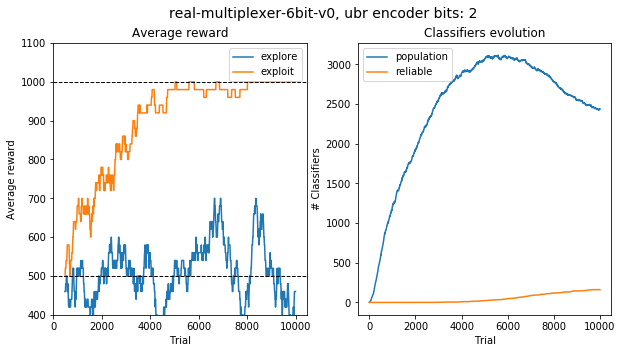

In [22]:
%%time
evaluate(rmpx6, encoder_bits=2, trials=10_000)

In [ ]:
%%time
# evaluate(rmpx6, encoder_bits=2, trials=15_000)